Data Analysis Pipeline:


*  Clone the repo to carry the dependencies over and to invoke imagene.py.
*  Import all necessary modules.


*   Simulate data for ancient and weak strength selection selrange = seq 0 100 100 / timerange = 0.1 100kya
*   Build and compile baseline model.


*   Train model on training data and gather metrics.Test model on the 10th batch of Data

In [1]:
# Cloning the GitHub repository
!git clone https://github.com/Djinho/EvoNet-CNN-Insight.git

# Change directories into the specified directory
%cd EvoNet-CNN-Insight/model_training/Ancient_weak

Cloning into 'EvoNet-CNN-Insight'...
remote: Enumerating objects: 4588, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 4588 (delta 99), reused 54 (delta 10), pack-reused 4379
Receiving objects: 100% (4588/4588), 5.83 GiB | 28.81 MiB/s, done.
Resolving deltas: 100% (1690/1690), done.
Updating files: 100% (84/84), done.
/content/EvoNet-CNN-Insight/model_training/Ancient_weak


In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import arviz

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, optimizers



# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, auc
import pydot  # Optional, but required by keras to plot the model

... and _ImaGene_.

In [3]:
%run -i ../../ImaGene.py

In [4]:

path = './'

Run and process simulations for neural network training using ImaGene's interface with msms.Params represent Ancient and . Example file params_binary simulates 200,000 loci with specific evolution and selection parameters. Follow Marth et al. 2004 model for a European population. Run simulations with ../generate_dataset.sh, splitting into batches for training.








In [6]:
#run for simulations
import subprocess
subprocess.call("bash ../../generate_dataset.sh params_Ancient_weak.txt".split());

perform first iteration of training on first batch of simulations in AW/Simulations1

In [7]:

path_sim = './'

In [8]:
file_sim = ImaFile(simulations_folder=path_sim + 'AW/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

populate an ImaGene object, specifying the variable to estimate (selection_coeff_hetero) and the desired number of data points per class. For this example, I will use 2000 data points per class

In [9]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000);

We can have a look at the data stored in this object.

In [10]:
gene_sim.summary();

An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 172, max 467, mean 318.961500, std 50.104740


use ImaGene to manipulate data by converting ancestral/derived to major/minor allele polarization, filtering columns by minimum allele frequency (e.g., 0.01), and sorting rows and columns by frequency or genetic distance. This ensures our data processing matches the real data's methodology.

In [11]:
# Filter out data points with frequency less than 0.01
gene_sim.filter_freq(0.01)

# Sort data by row frequency
gene_sim.sort('rows_freq')

# Print a summary of the simulation data
gene_sim.summary()


An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 95, max 374, mean 231.252000, std 48.393703


In [12]:
# Resize the simulation data to the specified shape (198 samples, 192 features)
gene_sim.resize((198, 192))

# Print a summary of the simulation data
gene_sim.summary()


An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


After the data manipulation is done, we need to convert images to proper _numpy_ float matrices,as previously discussed. The following line will do the job (including flipping black/white pixels).
Note that the `.convert` method allows you to normalise the data too.

In [13]:
# Convert the simulation data, applying flipping if specified
gene_sim.convert(flip=True)

# Print a summary of the simulation data
gene_sim.summary()


An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


Note that in addition to the genomic data, an _ImaGene_ object contains information on the corresponding targets (in this case the selection coefficient, either 0 or 300 in $2N_e$ units with $N_e = 10000$).
As an illustration, let's plot one random image per class.

0


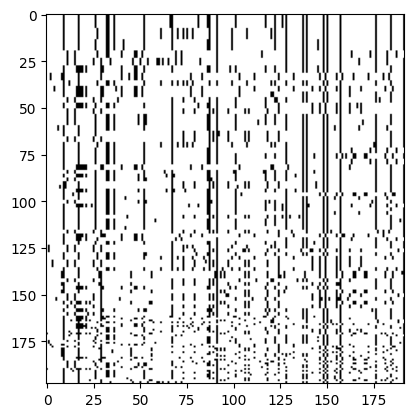

100


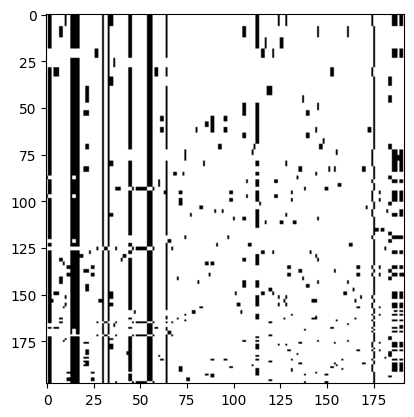

In [14]:
# Iterate over each class in the simulation data
for sel in gene_sim.classes:
    # Print the current class
    print(sel)
    # Plot the first occurrence of the current class in the targets
    gene_sim.plot(np.where(gene_sim.targets == sel)[0][0])


randomly shuffle images before using them to train

In [15]:
gene_sim.subset(get_index_random(gene_sim));

Vectorise classes as required by keras

In [16]:
gene_sim.targets = to_binary(gene_sim.targets);

In [17]:
gene_sim.save(file=path + 'gene_sim.binary')

0

If you want to load an _ImaGene_ object you can use the following function.

In [18]:
gene_sim = load_imagene(file=path + 'gene_sim.binary')

build the neural network using Keras. Baseline model ImaGene offers will have three layers of 2D convolutions and pooling, followed by a fully connected layer. specify the input dimensions using input_shape=gene_sim.data.shape[1:] in the first layer.

In [19]:
# Build the neural network model
model = models.Sequential([
    # First convolutional layer with L1 and L2 regularization, ReLU activation, and valid padding
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid',
                  input_shape=gene_sim.data.shape[1:]),
    # First max pooling layer with a 2x2 pool size
    layers.MaxPooling2D(pool_size=(2,2)),

    # Second convolutional layer with L1 and L2 regularization, ReLU activation, and valid padding
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
    # Second max pooling layer with a 2x2 pool size
    layers.MaxPooling2D(pool_size=(2,2)),

    # Third convolutional layer with L1 and L2 regularization, ReLU activation, and valid padding
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
    # Third max pooling layer with a 2x2 pool size
    layers.MaxPooling2D(pool_size=(2,2)),

    # Flatten the output from the convolutional layers to feed into the fully connected layers
    layers.Flatten(),

    # Fully connected layer with 128 units and ReLU activation
    layers.Dense(units=128, activation='relu'),

    # Output layer with 1 unit and sigmoid activation for binary classification
    layers.Dense(units=1, activation='sigmoid')
])

Then, let's compile our _keras_ model.

In [20]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Let's look at a summary of the model and plot it.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 190, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 98, 95, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 93, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 46, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 44, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 22, 64)        0

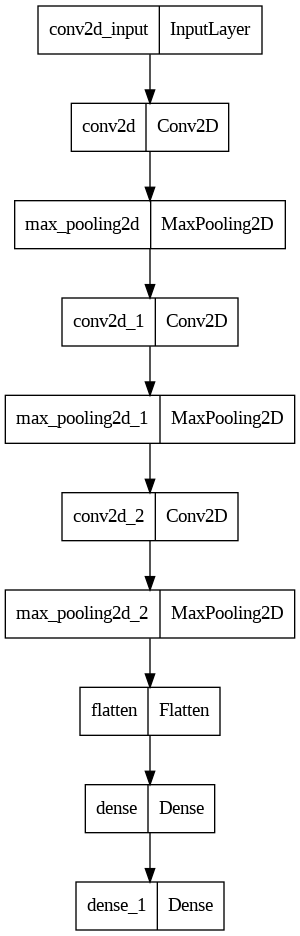

In [21]:
model.summary()
plot_model(model, path + 'net.binary.png')

Now we are ready for doing the training on this first batch of data.

In [22]:
score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)

29/29 [==============================] - 93s 3s/step - loss: 6.0876 - accuracy: 0.5394 - val_loss: 4.4271 - val_accuracy: 0.6350


initialise a network with _ImaNet_.

In [24]:
net_LCT = ImaNet(name='[C32+P]x2+[C64+P]+D128')

In [25]:
net_LCT.update_scores(score);

Now we need to repeat the whole procedure described above using all remaning batches of data, leaving the last one for testing.

In [26]:
i = 2
while i < 10:
    # Print the current iteration number
    print(i)

    # Create an ImaFile instance for the current simulation folder
    file_sim = ImaFile(simulations_folder=path_sim + 'AW/Simulations' + str(i),
                       nr_samples=198, model_name='Marth-3epoch-CEU')

    # Read the simulations for the specified parameter and max number of replications
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

    # Filter out data points with frequency less than 0.01
    gene_sim.filter_freq(0.01)

    # Sort the data by row frequency
    gene_sim.sort('rows_freq')

    # Resize the simulation data to the shape (198, 192)
    gene_sim.resize((198, 192))

    # Convert the data, applying flipping if specified
    gene_sim.convert(flip=True)

    # Subset the data randomly
    gene_sim.subset(get_index_random(gene_sim))

    # Convert the targets to binary format
    gene_sim.targets = to_binary(gene_sim.targets)

    # Fit the model to the data for 1 epoch with a batch size of 64 and 10% validation split
    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)

    # Update the scores in net_LCT with the current model score
    net_LCT.update_scores(score)

    # Increment the iteration counter
    i += 1


2
29/29 [==============================] - 81s 3s/step - loss: 2.1429 - accuracy: 0.5328 - val_loss: 1.6296 - val_accuracy: 0.5100
3
29/29 [==============================] - 82s 3s/step - loss: 1.3325 - accuracy: 0.5639 - val_loss: 1.0838 - val_accuracy: 0.5250
4
29/29 [==============================] - 81s 3s/step - loss: 0.9645 - accuracy: 0.5217 - val_loss: 0.8765 - val_accuracy: 0.5050
5
29/29 [==============================] - 83s 3s/step - loss: 0.8366 - accuracy: 0.5439 - val_loss: 0.8074 - val_accuracy: 0.5600
6
29/29 [==============================] - 81s 3s/step - loss: 0.7972 - accuracy: 0.5022 - val_loss: 0.7850 - val_accuracy: 0.4800
7
29/29 [==============================] - 87s 3s/step - loss: 0.7767 - accuracy: 0.4956 - val_loss: 0.7697 - val_accuracy: 0.4200
8
29/29 [==============================] - 92s 3s/step - loss: 0.7664 - accuracy: 0.4761 - val_loss: 0.7643 - val_accuracy: 0.4650
9
29/29 [==============================] - 87s 3s/step - loss: 0.7635 - accuracy: 0

plot loss and validation accuracy during the training to check, for instance, for overfitting.

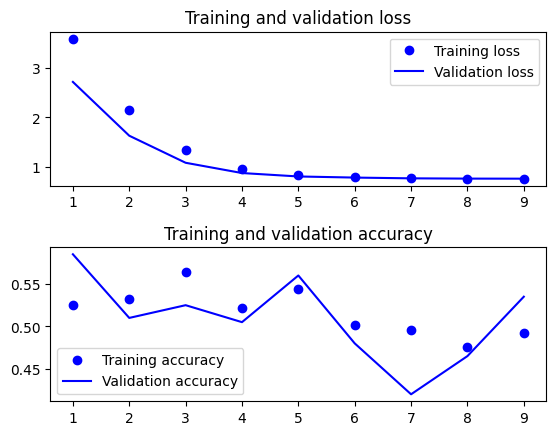

0

In [27]:
net_LCT.plot_train()

Save trained model

In [28]:
model.save(path + 'model.AW.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
model = load_model(path + 'model.AW.h5')

In [30]:
net_LCT.save(path + 'AW.binary');

In [31]:
net_LCT = load_imanet(path + 'AW.binary')

Evaluate the training on the testing dataset, i.e. the last batch of simulated data.

In [35]:
i = 10

# Create an ImaFile instance for the 10th simulation folder
file_sim = ImaFile(simulations_folder=path_sim + 'AW/Simulations' + str(i),
                   nr_samples=198, model_name='Marth-3epoch-CEU')

# Read the test simulations for the specified parameter and max number of replications
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

# Filter out data points with frequency less than 0.01
gene_sim_test.filter_freq(0.01)

# Sort the data by row frequency
gene_sim_test.sort('rows_freq')

# Resize the simulation data to the shape (198, 192)
gene_sim_test.resize((198, 192))

# Convert the data, applying flipping if specified
gene_sim_test.convert(flip=True)

# Subset the data randomly without creating an extra variable
gene_sim_test.subset(get_index_random(gene_sim_test))

# Convert the targets to binary format
gene_sim_test.targets = to_binary(gene_sim_test.targets)


BadGzipFile: Not a gzipped file (b'\x1f\xef')

In [ ]:
# Evaluate the model on the test data and targets
# Outputs a list: [loss, accuracy]
net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)

# Print the evaluation results
print(net_LCT.test)  # [loss, accuracy]


In [ ]:
# Add the following code for ROC and AUC calculation and plotting
y_pred_prob = model.predict(gene_sim_test.data)
fpr, tpr, _ = roc_curve(gene_sim_test.targets, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(gene_sim_test.targets, y_pred).ravel()

# Calculate sensitivity (recall)
sensitivity = recall_score(gene_sim_test.targets, y_pred)

# Calculate specificity
specificity = tn / (tn + fp)

# Calculate precision
precision = precision_score(gene_sim_test.targets, y_pred)

# Calculate F1 score
f1 = f1_score(gene_sim_test.targets, y_pred)

# Print metrics
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

For a binary (or multiclass) classification, it is convenient to plot the confusion matrix after predicting the responses from the testing data.

In [ ]:
net_LCT.predict(gene_sim_test, model)
net_LCT.plot_cm(gene_sim_test.classes, text=True)